In [134]:
import torch
import pandas as pd
from torch.utils.data import Dataset
import re
import os
import scipy.misc
from PIL import Image
import PIL
from skimage.color import rgb2gray
from scipy.signal import convolve
from sklearn.utils import shuffle
from torch import nn
import numpy as np
from torch.autograd import Variable
import cv2
from skimage import io, transform
import matplotlib.pyplot as plt
from  torchvision.transforms import Compose
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
!ls
%matplotlib inline

1.ipynb                          faces
Dataset Description.pdf          final.ipynb
Test                             satellite-image-object-detection
Train                            train_cropped
data_loading_tutorial.ipynb      vgg16_weights.h5


# READ

In [2]:
img_input = np.array(Image.open("Train/2012-04-26-Muenchen-Tunnel_4K0G0010.JPG"), np.uint8)

In [3]:
pd.set_option('display.width', 1000)

In [5]:
path_landmark = "Train/2012-04-26-Muenchen-Tunnel_4K0G0010_pkw.samp"
def read_csv(path_landmark):
    names = ['id', 'type', 'center.x', 'center.y', 'size.width', 'size.height', 'alpha']
    cars_landmarks = pd.read_table(path_landmark, skiprows=6, delimiter=' ', names = names)
    return cars_landmarks

In [ ]:
#Все файлы samp в папке 
reg = r'(\w+)\_truck.samp'
INPUT_PATH='./Train/'
def extract_names(f):
    m = re.search(r'(\w+)\_truck.samp', f);
    if m is not None:
        return (f) ;
    
files = os.listdir(INPUT_PATH);
files = sorted(files)
names = map(extract_names, files)
only_cars = [name for name in names if name !=None]

In [6]:
def integ(a):
    new =[]
    for item in a:
        new.append(int(float(item)))
    return new

In [7]:
in_folder  = './train_cropped/'

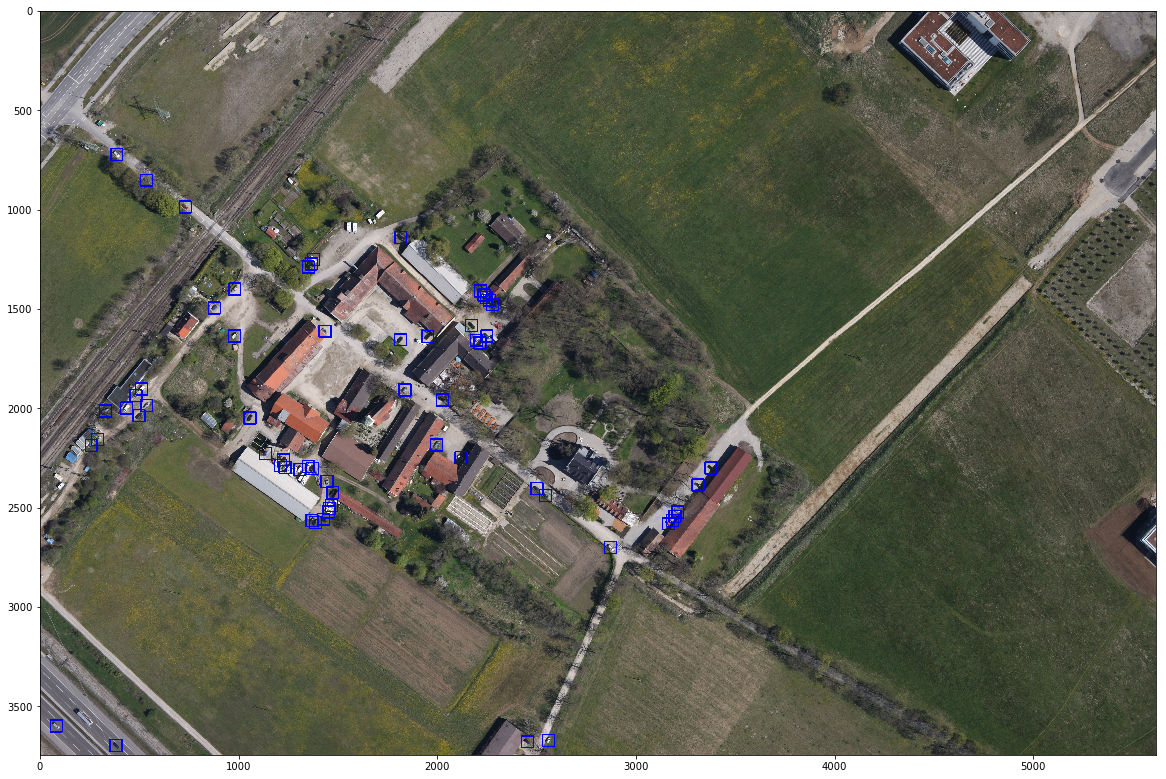

In [8]:
image = img_input.copy()
train_landmarks = read_csv(path_landmark)
facts = pd.DataFrame([], columns=['index', 'target'])
spce = 30
facts = pd.DataFrame([], columns=['index', 'target'])
ROWS = 60
COLS = 60
CHANNELS = 3

data = np.ndarray((945, ROWS, COLS, CHANNELS), dtype=np.uint8)

counter = 0
for i,car in enumerate(train_landmarks.values):
    #print(car)
    temp_car = integ(car[2:6])
    #car
    x1 = temp_car[0] - spce
    y1 = temp_car[1] - spce
    x2 = temp_car[0] + spce
    y2 = temp_car[1] + spce
    image_array = img_input[y1:y2,x1:x2,:]
    data[counter] = image_array
    df_temp = pd.DataFrame([[counter, 1]], columns=['index', 'target'])
    facts = facts.append(df_temp)
    counter+=1
    for j in range(0,5):
        alpha = random.randint(-180,180)
        im = Image.fromarray(np.uint8(image_array))
        im = im.rotate(alpha)
        imaged = np.asarray(im)
        data[counter] = imaged
        df_temp = pd.DataFrame([[counter, 1]], columns=['index', 'target'])
        facts = facts.append(df_temp)
        counter+=1
        
    #save one
    ima = Image.fromarray(imaged)
    ima.save(in_folder+'{}.jpg'.format(counter))
        
    #background
    back_ground = img_input[x1:x2,y1:y2,:]
    data[counter] = back_ground
    df_temp = pd.DataFrame([[counter, 0]], columns=['index', 'target'])
    facts = facts.append(df_temp)
    counter+=1
    for j in range(0,8):
        alpha = random.randint(-180,180)
        im = Image.fromarray(np.uint8(back_ground))
        im = im.rotate(alpha)
        imaged = np.asarray(im)
        data[counter] = imaged
        df_temp = pd.DataFrame([[counter, 0]], columns=['index', 'target'])
        facts = facts.append(df_temp)
        counter+=1
        
    ima = Image.fromarray(imaged)
    ima.save(in_folder+'{}.jpg'.format(counter))
    

    
    cv2.rectangle(image,(x1,y1),(x2,y2),(0,0,255),5)
    
    #cv2.imshow("img",image);
    #fig2 = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
    #ax3 = fig2.add_subplot(111)
    #ax3.imshow(image, interpolation='none')

plt.figure(figsize = (20,20))
plt.imshow(image)

# TRAIN

In [249]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold, cross_val_score
from keras import losses
import keras
from keras import optimizers
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [16]:
y_train = facts['target'].values
x_train = data

In [17]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[3], x_train.shape[1], x_train.shape[2])

In [185]:
predict_proba = model.predict(x_train)

In [191]:
type(predict_proba)

numpy.ndarray

In [1]:
#predict_proba.tolist()

In [186]:
predict = (predict_proba>0.5).astype(int).ravel()

In [189]:
x_train.shape

(945, 3, 60, 60)

In [190]:
type(x_train)

numpy.ndarray

In [188]:
f1_score(list(y_train), list(predict))

0.99473684210526314

In [277]:
total_loss = []
class Metrics(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        predict_proba = self.model.predict(self.validation_data[0])
        targ = self.validation_data[1].tolist()
        predict = (predict_proba>0.5).astype(int).ravel().tolist()
        self.f1s=f1_score(targ, predict)
        #print(type(predict), type(targ))
        total_loss.append(self.f1s)
        print(' fscore: {}'.format(self.f1s))
        return
f1_measure = Metrics()

In [278]:
ROWS = 60
COLS = 60

    
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=(3, 60, 60), activation='relu' , data_format="channels_first"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# model.add(Conv2D(128, (3, 3), border_mode='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))



model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [279]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        #print (logs.get('loss'))
        self.losses.append(logs.get('loss'))

In [280]:
from keras import backend as K

In [281]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))


In [283]:
nb_epoch = 10
batch_size = 16
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

model.compile(loss=objective, optimizer=optimizer, metrics=[f1])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')    
history = LossHistory()


model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping, f1_measure])

Train on 708 samples, validate on 237 samples
Epoch 1/10
708/708 [==============================] - 41s - loss: 1.3924 - f1: nan - val_loss: 0.5699 - val_f1: nan
Epoch 2/10
708/708 [==============================] - 39s - loss: 0.6851 - f1: nan - val_loss: 0.5538 - val_f1: nan
Epoch 3/10
708/708 [==============================] - 36s - loss: 0.5556 - f1: 0.6749 - val_loss: 0.4707 - val_f1: 0.7828
Epoch 4/10
708/708 [==============================] - 39s - loss: 0.5069 - f1: nan - val_loss: 0.3772 - val_f1: 0.8518
Epoch 5/10
708/708 [==============================] - 40s - loss: 0.4853 - f1: 0.7156 - val_loss: 0.2887 - val_f1: 0.8748
Epoch 6/10
708/708 [==============================] - 36s - loss: 0.4344 - f1: nan - val_loss: 0.2537 - val_f1: 0.8789
Epoch 7/10
708/708 [==============================] - 36s - loss: 0.3945 - f1: 0.7544 - val_loss: 0.2362 - val_f1: 0.8805
Epoch 8/10
708/708 [==============================] - 48s - loss: 0.3145 - f1: nan - val_loss: 0.4579 - val_f1: nan
Ep

In [110]:
y_proba = model.predict(x_train)

In [57]:
pred_classes = model.predict_classes(x_train)

945/945 [==============================] - 17s    


In [111]:
pred_classes = pred_classes.ravel()

In [112]:
f1_score(list((y_proba>0.5).astype(int).ravel()), list(y_train))

0.93680297397769507

In [114]:
img_input.shape

(3744, 5616, 3)

In [ ]:
image[0:60,0:60,:]

In [ ]:
image.reshape()

In [131]:
list(model.predict(image[0:60,0:60,:].reshape(1,3,60,60))[0])[0]

0.00073698105

In [120]:
image.shape

(3744, 5616, 3)

In [ ]:
temp_image = image[:y2, x1:x2,:].reshape(1,3,60,60)

In [149]:
im = image[0:60,0:60,:]
im.shape

(60, 60, 3)

In [150]:
im.reshape(1,3,60,60)

array([[[[70, 77, 69, ..., 99, 94, 75],
         [91, 88, 71, ..., 60, 68, 53],
         [59, 67, 54, ..., 64, 67, 56],
         ..., 
         [80, 87, 71, ..., 60, 71, 54],
         [61, 72, 55, ..., 56, 68, 58],
         [56, 68, 58, ..., 76, 78, 65]],

        [[80, 84, 69, ..., 57, 71, 54],
         [58, 72, 55, ..., 57, 69, 59],
         [57, 67, 58, ..., 73, 75, 62],
         ..., 
         [63, 71, 60, ..., 58, 68, 57],
         [61, 68, 60, ..., 61, 71, 62],
         [64, 74, 65, ..., 69, 75, 63]],

        [[57, 67, 59, ..., 60, 70, 59],
         [62, 70, 59, ..., 65, 75, 66],
         [70, 78, 67, ..., 67, 75, 60],
         ..., 
         [57, 67, 56, ..., 60, 70, 59],
         [58, 68, 59, ..., 67, 75, 64],
         [65, 73, 62, ..., 71, 72, 58]]]], dtype=uint8)

100%|██████████| 92/92 [01:37<00:00,  1.06s/it]


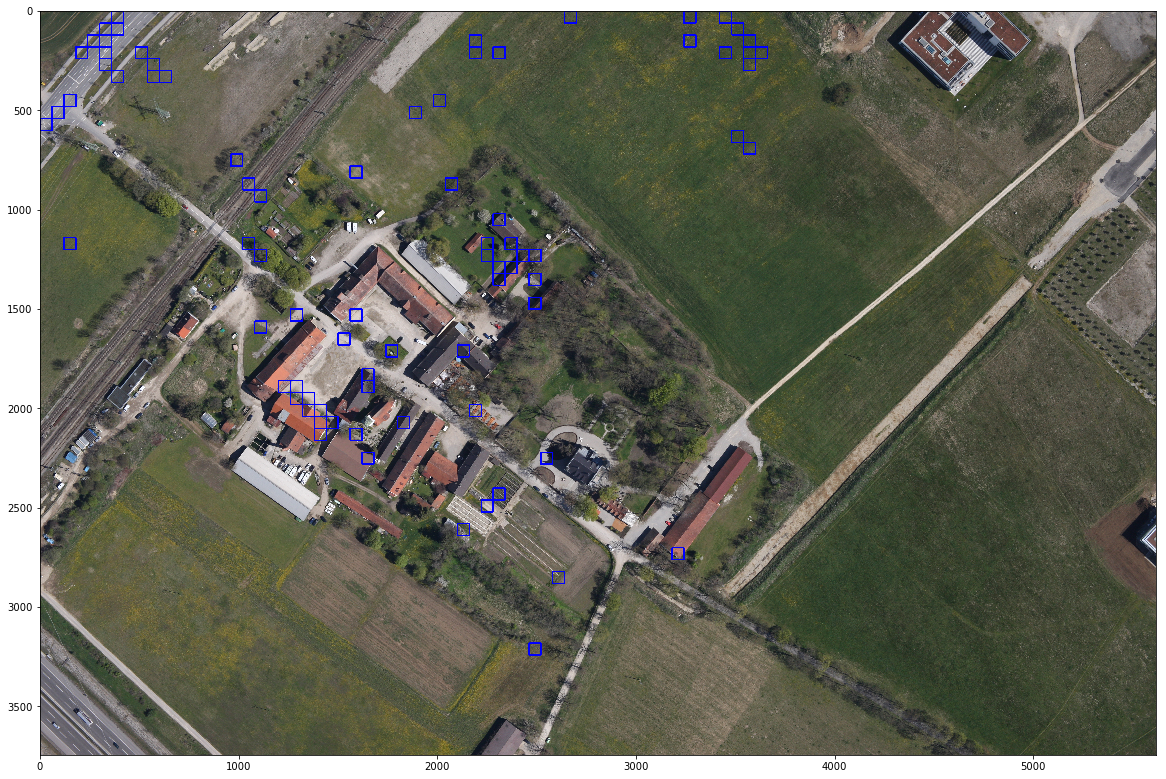

In [284]:
image = img_input.copy()
threshold = adds
#по x двигаюсь от (0, 5580)
#по y двигуюсь от (0, 3720)
for i in tqdm(range(0,5520,60)):
    for j in range(0,3660,60):
        x1 = j
        y1 = i
        x2 = j+60
        y2 = i+60
        #print(x1,y1)
        temp_image = image[x1:x2, y1:y2,:].reshape(1,3,60,60)
        pred_proba = model.predict(temp_image)[0]
        pred_prob = list(pred_proba)[0]
        if pred_prob>threshold:
            cv2.rectangle(image,(x1,y1),(x2,y2),(0,0,255),5)
        
plt.figure(figsize = (20,20))
plt.imshow(image)            

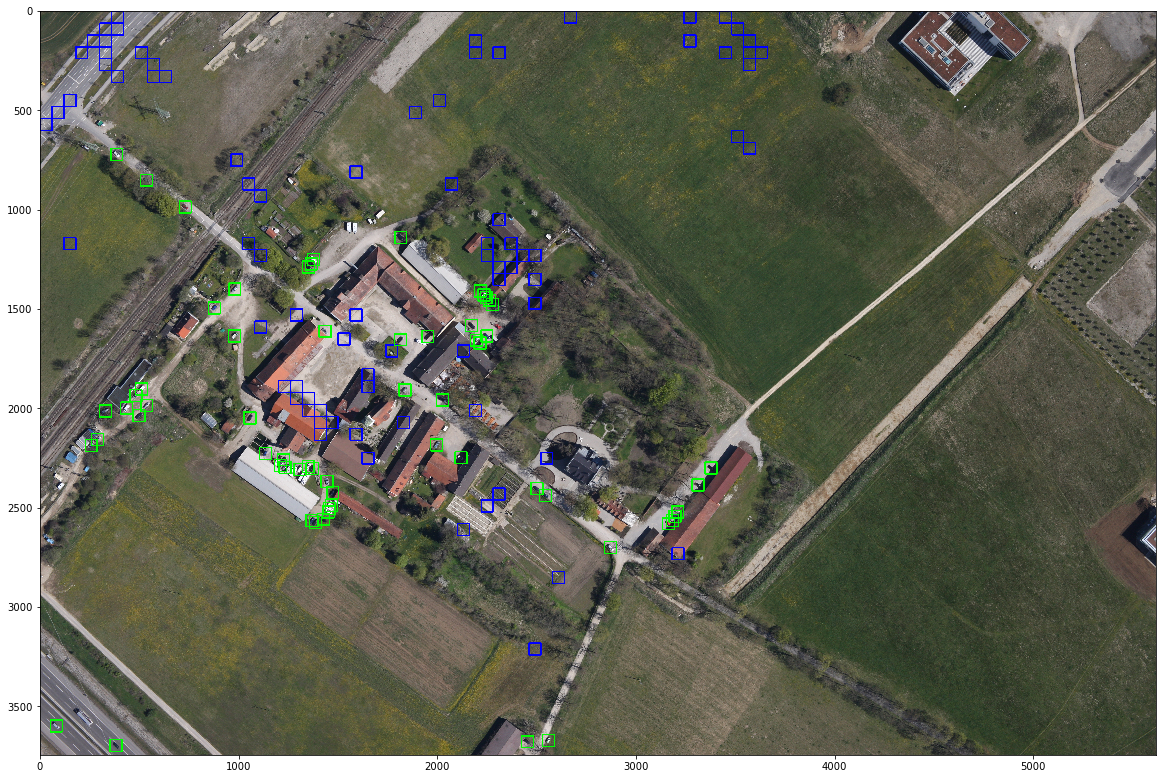

In [285]:
for i,car in enumerate(train_landmarks.values):
    #print(car)
    temp_car = integ(car[2:6])
    #car
    x1 = temp_car[0] - spce
    y1 = temp_car[1] - spce
    x2 = temp_car[0] + spce
    y2 = temp_car[1] + spce
    cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),5)
plt.figure(figsize = (20,20))
plt.imshow(image)     

In [171]:
from __future__ import division

In [286]:
max_ =0.0
adds= 0
for i in range(0,10000):
    rank = i/10000
    temp_score = f1_score(list((y_proba>rank).astype(int).ravel()), list(y_train))
    if temp_score>max_:
        max_= temp_score
        adds = rank

In [287]:
adds

0.9074

In [288]:
f1_score(list((y_proba>adds).astype(int).ravel()), list(y_train))

0.99734748010610075

In [290]:
recall_score(list((y_proba>adds).astype(int).ravel()), list(y_train))

1.0